# VizDoom Playground

In [10]:
import itertools as it
import json
import os

import gym
from gym.spaces import Box, Discrete
import matplotlib.pyplot as plt
import numpy as np
import vizdoom as vzd

from rlpyt.envs.vizdoom.vizdoom_env import VizDoomEnv

vzd_dir = 'vizdoom_data'

## Player Control

In [13]:
game = vzd.DoomGame()
game.load_config('vizdoom_data/my_way_home_control.cfg')
game.set_seed(0)
game.init()
game.new_episode()
while not game.is_episode_finished():
    s = game.get_state()
    game.advance_action()
    a = game.get_last_action()
    r = game.get_last_reward()
game.close()

## Replay Episode

In [ ]:
game = vzd.DoomGame()
game.load_config('vizdoom_data/my_way_home_control.cfg')
game.init()
game.replay_episode('../data/local/20200722/vizdoom/run_0/eval_run_0_itr_0.lmp')
while not game.is_episode_finished():
    game.advance_action()
game.close()

## MyWayHome

In [14]:
env = VizDoomEnv('vizdoom_data/my_way_home.cfg', 0, [1040, -300], 270)

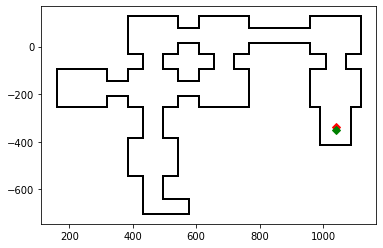

In [15]:
env.plot_topdown()

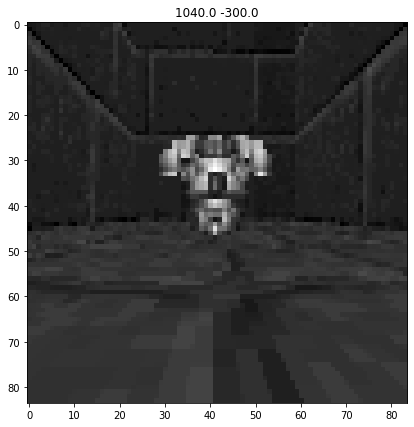

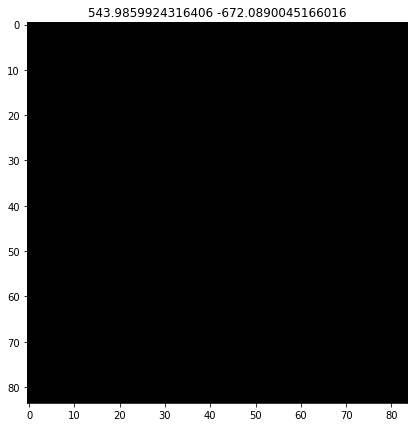

In [18]:
for state, position in env.sample_states[:2]:
    plt.figure(figsize=(7, 7))
    plt.imshow(state[-2], cmap='gray')
    plt.title('{} {}'.format(*position))

In [ ]:
obs = env.reset()

In [ ]:
env.plot_topdown()

In [ ]:
plt.imshow(env.goal_state[-1], cmap='gray')

In [ ]:
env.plot_topdown()

In [ ]:
state = env.state

In [ ]:
state.sectors[0].lines[5].y2

In [ ]:
env.goal_position

In [ ]:
env.game.get_game_variable(vzd.GameVariable.ANGLE)

In [ ]:
env.game.send_game_command("warp 1040 -300")

In [ ]:
obs, reward, done, info = env.step(3)

In [ ]:
done

In [ ]:
env.state.game_variables

In [ ]:
plt.imshow(obs[-1], cmap='gray')

In [ ]:
for i in range(500):
    obs, reward, done, info = env.step(np.random.randint(3))
    if done:
        print(reward, i + 1)
        break

In [ ]:
env.plot_topdown()

In [ ]:
plt.imshow(env.visited.T, origin='lower')